# fanout和冗余度的关系

图表将保存到目录: d:\kk\Desktop\CS305-2025Spring-FinalProject_real\redundancy_charts\redundancy_plots

Processing file: redundancy_data_5_peers.csv...
Successfully read with separator ','
Cleaned and lowercased columns: ['timestamp', 'peer_id', 'message_redundancy', 'redundant_blocks', 'redundant_txs']
  Number of time points for 5 nodes: 13
  First 5 average data points for 5 nodes:
     rel_time  message_redundancy
0    0.000000                 0.2
1   60.069230                24.8
2  120.134751                45.6
3  180.192373                71.6
4  240.297892                92.4

Processing file: redundancy_data_11_peers.csv...
Successfully read with separator ','
Cleaned and lowercased columns: ['timestamp', 'peer_id', 'message_redundancy', 'redundant_blocks', 'redundant_txs']
  Number of time points for 11 nodes: 16
  First 5 average data points for 11 nodes:
     rel_time  message_redundancy
0    0.000000            0.090909
1   60.182090           22.090909
2  120.283078           42.

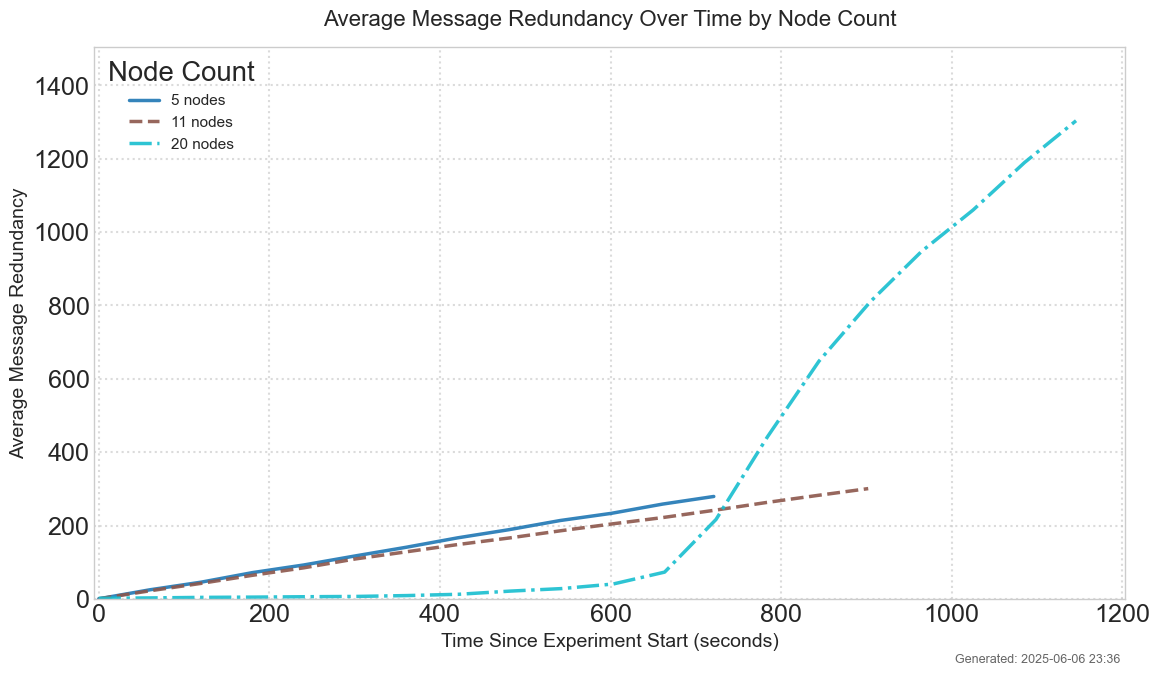

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from datetime import datetime
import traceback # 用于打印详细的错误信息

# 设置全局样式
available_styles = plt.style.available
if 'seaborn-whitegrid' in available_styles:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn-v0_8-whitegrid' in available_styles:
    plt.style.use('seaborn-v0_8-whitegrid')
elif 'seaborn' in available_styles:
    plt.style.use('seaborn')
else:
    plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica', 'Verdana']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

def plot_node_redundancy_comparison(node_counts, output_dir="redundancy_plots"):
    """
    使用 Matplotlib 绘制不同节点数下的平均冗余消息数随时间变化
    
    Args:
        node_counts (list): 包含节点数的列表，例如 [5, 11, 20]
        output_dir (str): 保存生成图表的目录名称
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"图表将保存到目录: {os.path.abspath(output_dir)}\n")
    
    # 准备颜色和线型
    # 确保颜色和线型数量足够，或循环使用
    colors = plt.cm.tab10(np.linspace(0, 1, len(node_counts)))
    styles = ["-", "--", "-.", ":", (0, (5, 5)), (0, (3, 1, 1, 1))] # 增加一些线型
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 存储每条曲线的最大时间用于设置坐标轴范围
    max_time = 0
    
    for i, node_count in enumerate(node_counts):
        filename = f"redundancy_data_{node_count}_peers.csv" 
        print(f"Processing file: {filename}...")
        
        if not os.path.exists(filename):
            print(f"✘ File {filename} not found, skipping\n")
            continue
            
        try:
            df = None
            # 尝试不同的分隔符读取文件
            for sep in [',', '\t']:
                try:
                    temp_df = pd.read_csv(filename, sep=sep)
                    # 检查是否成功读取且包含一些数据
                    if not temp_df.empty:
                        df = temp_df
                        print(f"Successfully read with separator '{sep}'")
                        break
                except pd.errors.ParserError:
                    continue # 尝试下一个分隔符
                except Exception as e:
                    print(f"Error reading file with separator '{sep}': {e}")
            
            if df is None or df.empty:
                print(f"✘ File {filename} could not be read or is empty, skipping\n")
                continue

            # 清理列名：去除前后空格，并转换为小写
            df.columns = [col.strip().lower() for col in df.columns]
            print(f"Cleaned and lowercased columns: {list(df.columns)}")
            
            # --- 核心修改：精确选择和重命名列 ---
            # 查找时间戳列
            timestamp_col_name = None
            for col in df.columns:
                if 'timestamp' in col or 'time' in col:
                    timestamp_col_name = col
                    break
            
            # 查找消息冗余度列
            redundancy_col_name = None
            for col in df.columns:
                if 'message_redundancy' == col or 'messageredundancy' == col: # 精确匹配
                    redundancy_col_name = col
                    break

            if timestamp_col_name is None:
                print(f"✘ 'timestamp' column not found in {filename}, skipping\n")
                continue
            if redundancy_col_name is None:
                print(f"✘ 'message_redundancy' column not found in {filename}, skipping\n")
                continue
            
            # 创建一个只包含所需数据的新DataFrame，并确保列名正确
            df_processed = df[[timestamp_col_name, redundancy_col_name]].copy()
            df_processed.columns = ['timestamp', 'message_redundancy'] # 统一列名
            
            # 将timestamp列转换为datetime对象，并处理转换失败的行
            df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'], errors='coerce')
            df_processed.dropna(subset=['timestamp'], inplace=True)
            
            # 转换冗余度为数值，并删除NaN值
            df_processed['message_redundancy'] = pd.to_numeric(df_processed['message_redundancy'], errors='coerce')
            df_processed.dropna(subset=['message_redundancy'], inplace=True)
            
            # 最终有效性检查
            if df_processed.empty:
                print(f"✘ File {filename} has no valid data after cleaning, skipping\n")
                continue
                
            # 计算实验开始的基准时间
            start_time = df_processed['timestamp'].min()
            
            # 计算相对时间（秒）
            df_processed['rel_time'] = (df_processed['timestamp'] - start_time).dt.total_seconds()
            
            # 计算每个时间戳的平均消息冗余度
            # 确保对处理后的df_processed进行操作
            avg_redundancy = df_processed.groupby('rel_time')['message_redundancy'].mean().reset_index()
            
            # 检查分组后的结果是否为空
            if avg_redundancy.empty:
                print(f"✘ File {filename} has no valid average redundancy data after grouping, skipping\n")
                continue

            # 更新最大时间
            current_max_time = avg_redundancy['rel_time'].max()
            max_time = max(max_time, current_max_time)
            
            print(f"  Number of time points for {node_count} nodes: {len(avg_redundancy)}")
            print(f"  First 5 average data points for {node_count} nodes:\n{avg_redundancy.head()}\n")
            
            # 绘制曲线
            ax.plot(
                avg_redundancy['rel_time'],
                avg_redundancy['message_redundancy'],
                label=f"{node_count} nodes",
                color=colors[i],
                linestyle=styles[i % len(styles)],
                linewidth=2.5,
                alpha=0.9
            )
            
        except Exception as e:
            print(f"‼️ Error processing file {filename}: {str(e)}")
            traceback.print_exc() # 打印完整的错误堆栈，便于调试
            print()
    
    # 如果没有绘制任何数据
    if not ax.lines:
        print("✘ No valid data to plot. Exiting.")
        return
    
    # 设置图表属性
    ax.set_title("Average Message Redundancy Over Time by Node Count", fontsize=16, pad=15)
    ax.set_xlabel("Time Since Experiment Start (seconds)", fontsize=14)
    ax.set_ylabel("Average Message Redundancy", fontsize=14)
    
    # 设置坐标轴范围
    ax.set_xlim(left=-5, right=max_time * 1.05)  # 添加5%的缓冲
    
    # 自动调整Y轴范围，添加10%的缓冲
    # 确保Y轴从0开始
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(bottom=0, top=y_max * 1.1)
    
    # 添加网格
    ax.grid(True, linestyle=':', alpha=0.7)
    
    # 添加图例
    # Matplotlib 默认会处理重复标签，但为了确保万无一失，可以手动过滤
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels.append(l)
            unique_handles.append(h)
    ax.legend(unique_handles, unique_labels, title="Node Count", loc='best', fontsize=11)
    
    
    # 保存并显示图表
    plt.tight_layout()
    
    # 保存图表
    plot_path = os.path.join(output_dir, "node_count_redundancy_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ 图表已保存至: {plot_path}\n")
    
    plt.show()

# 在Jupyter Notebook单元格中直接调用此函数
# 确保你的工作目录下有 redundancy_data_5_peer.csv, redundancy_data_11_peer.csv, redundancy_data_20_peer.csv 文件
plot_node_redundancy_comparison(node_counts=[5, 11, 20])

# 节点数量与冗余度的关系

图表将保存到目录: d:\kk\Desktop\CS305-2025Spring-FinalProject_real\redundancy_charts\redundancy_plots

Processing file: redundancy_data_5_peers.csv...
Successfully read with separator ','
File columns: ['timestamp', 'peer_id', 'message_redundancy', 'redundant_blocks', 'redundant_txs']
Cleaned columns: ['timestamp', 'peer_id', 'message_redundancy', 'redundant_blocks', 'redundant_txs']
Number of time points: 13
First 5 data points:
     rel_time  message_redundancy  message_redundancy  message_redundancy
0    0.000000                 0.2                 0.0                 0.0
1   60.069230                24.8                 0.0                 0.0
2  120.134751                45.6                 0.0                 0.0
3  180.192373                71.6                 0.0                 0.0
4  240.297892                92.4                 0.0                 0.0

Processing file: redundancy_data_11_peers.csv...
Successfully read with separator ','
File columns: ['timestamp', 'peer_id', 'mes

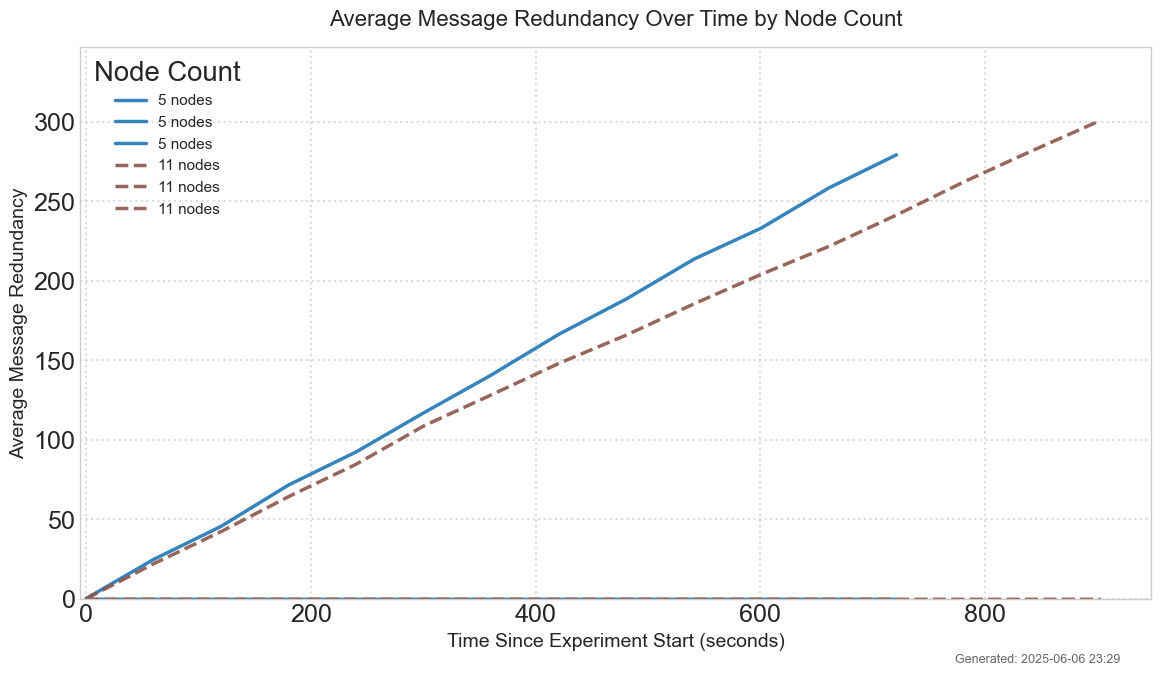

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from datetime import datetime

# 设置全局样式
available_styles = plt.style.available
if 'seaborn-whitegrid' in available_styles:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn-v0_8-whitegrid' in available_styles:
    plt.style.use('seaborn-v0_8-whitegrid')
elif 'seaborn' in available_styles:
    plt.style.use('seaborn')
else:
    plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica', 'Verdana']
plt.rcParams['axes.unicode_minus'] = False

def plot_node_redundancy_comparison(node_counts, output_dir="redundancy_plots"):
    """
    使用 Matplotlib 绘制不同节点数下的平均冗余消息数随时间变化
    
    Args:
        node_counts (list): 包含节点数的列表，例如 [5, 11, 20]
        output_dir (str): 保存生成图表的目录名称
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"图表将保存到目录: {os.path.abspath(output_dir)}\n")
    
    # 准备颜色和线型
    colors = plt.cm.tab10(np.linspace(0, 1, len(node_counts)))
    styles = ["-", "--", "-.", ":", (0, (5, 5))]
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 存储每条曲线的最大时间用于设置坐标轴范围
    max_time = 0
    
    for i, node_count in enumerate(node_counts):
        filename = f"redundancy_data_{node_count}_peers.csv"
        print(f"Processing file: {filename}...")
        
        if not os.path.exists(filename):
            print(f"File {filename} not found, skipping\n")
            continue
            
        try:
            # 尝试不同的分隔符读取文件
            for sep in [',', '\t']:
                try:
                    df = pd.read_csv(filename, sep=sep)
                    print(f"Successfully read with separator '{sep}'")
                    break
                except pd.errors.ParserError:
                    continue
                except Exception as e:
                    print(f"Error reading file with separator '{sep}': {e}")
            
            # 打印列名用于调试
            print(f"File columns: {list(df.columns)}")
            
            # 清理列名：去除前后空格
            df.columns = df.columns.str.strip()
            print(f"Cleaned columns: {list(df.columns)}")
            
            if df.empty:
                print(f"File {filename} is empty, skipping\n")
                continue
            
            # 重命名可能的变体列名
            col_mapping = {}
            for col in df.columns:
                lower_col = col.lower()
                if 'timestamp' in lower_col or 'time' in lower_col:
                    col_mapping[col] = 'timestamp'
                elif 'redund' in lower_col:
                    col_mapping[col] = 'message_redundancy'
            
            if 'timestamp' not in col_mapping.values():
                print("No timestamp column found, skipping\n")
                continue
            if 'message_redundancy' not in col_mapping.values():
                print("No redundancy column found, skipping\n")
                continue
            
            # 应用列重命名
            df.rename(columns=col_mapping, inplace=True)
            
            # 将timestamp列转换为datetime对象
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            if df['timestamp'].isnull().all():
                print("Timestamp conversion failed, skipping\n")
                continue
            
            # 删除无效的时间戳
            df.dropna(subset=['timestamp'], inplace=True)
            if df.empty:
                print("No valid timestamps after dropna, skipping\n")
                continue
            
            # 计算实验开始的基准时间
            start_time = df['timestamp'].min()
            
            # 计算相对时间（秒）
            df['rel_time'] = (df['timestamp'] - start_time).dt.total_seconds()
            
            # 计算每个时间戳的平均消息冗余度
            avg_redundancy = df.groupby('rel_time')['message_redundancy'].mean().reset_index()
            
            # 更新最大时间
            current_max_time = avg_redundancy['rel_time'].max()
            max_time = max(max_time, current_max_time)
            
            print(f"Number of time points: {len(avg_redundancy)}")
            print(f"First 5 data points:\n{avg_redundancy.head()}\n")
            
            # 绘制曲线
            ax.plot(
                avg_redundancy['rel_time'],
                avg_redundancy['message_redundancy'],
                label=f"{node_count} nodes",
                color=colors[i],
                linestyle=styles[i % len(styles)],
                linewidth=2.5,
                alpha=0.9
            )
            
        except Exception as e:
            print(f"Error processing file {filename}: {e}\n")
    
    # 如果没有绘制任何数据
    if not ax.lines:
        print("No valid data to plot. Exiting.")
        return
    
    # 设置图表属性
    ax.set_title("Average Message Redundancy Over Time by Node Count", fontsize=16, pad=15)
    ax.set_xlabel("Time Since Experiment Start (seconds)", fontsize=14)
    ax.set_ylabel("Average Message Redundancy", fontsize=14)
    
    # 设置坐标轴范围
    ax.set_xlim(left=-5, right=max_time * 1.05)  # 添加5%的缓冲
    
    # 自动调整Y轴范围，添加10%的缓冲
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(bottom=0, top=y_max * 1.1)
    
    # 添加网格
    ax.grid(True, linestyle=':', alpha=0.7)
    
    # 添加图例
    ax.legend(title="Node Count", loc='best', fontsize=11)
    
    # 添加数据来源信息
    plt.figtext(0.95, 0.02, 
                f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}", 
                ha='right', va='bottom', fontsize=9, alpha=0.7)
    
    # 保存并显示图表
    plt.tight_layout()
    
    # 保存图表
    plot_path = os.path.join(output_dir, "node_count_redundancy_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"图表已保存至: {plot_path}\n")
    
    plt.show()

if __name__ == "__main__":
    # 定义需要处理的节点数列表
    node_counts_to_analyze = [5, 11, 20]
    plot_node_redundancy_comparison(node_counts_to_analyze)

# 网络环境与冗余的关系

Processing: redundancy_data_speed_limit_10.csv (638 rows)
  Speed 10Mbps: 58 time points
Processing: redundancy_data_speed_limit_30.csv (319 rows)
  Speed 30Mbps: 29 time points
Processing: redundancy_data_speed_limit_100.csv (242 rows)
  Speed 100Mbps: 22 time points

Chart saved to: redundancy_plots\redundancy_comparison.png


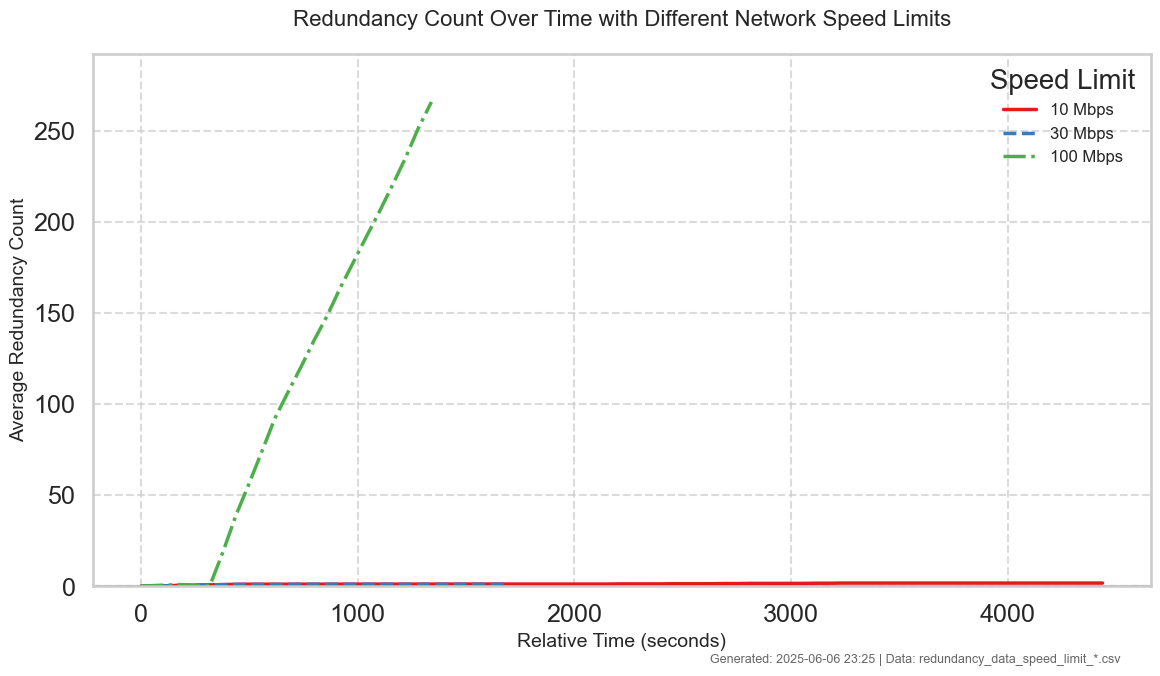

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

# 设置全局样式 - 避免任何中文字符
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.1)
plt.rcParams['font.family'] = 'sans-serif'  # 使用默认sans-serif字体
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica', 'Verdana']  # 跨平台安全字体

def plot_redundancy_comparison(speeds=[10, 30, 100]):
    """
    Plot redundancy count over time for different network speed limits
    Using relative time (seconds) on x-axis
    """
    # 颜色映射
    color_map = {
        10: "#e41a1c",  # red
        30: "#377eb8",  # blue
        100: "#4daf4a"  # green
    }
    
    # 样式映射
    style_map = {
        10: {"linestyle": "-", "linewidth": 2.5},
        30: {"linestyle": "--", "linewidth": 2.5},
        100: {"linestyle": "-.", "linewidth": 2.5}
    }
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for speed in speeds:
        filename = f"redundancy_data_speed_limit_{speed}.csv"
        
        if not os.path.exists(filename):
            print(f"File {filename} not found, skipping")
            continue
            
        try:
            # Read data
            df = pd.read_csv(filename)
            print(f"Processing: {filename} ({len(df)} rows)")
            
            # Convert timestamps
            df['datetime'] = pd.to_datetime(df['timestamp'])
            start_time = df['datetime'].min()
            
            # Calculate relative time (seconds)
            df['rel_time'] = (df['datetime'] - start_time).dt.total_seconds()
            
            # Group by time and calculate average redundancy count
            time_grouped = df.groupby('rel_time')['message_redundancy'].mean().reset_index()
            
            # Get number of data points
            points = len(time_grouped)
            print(f"  Speed {speed}Mbps: {points} time points")
            
            # Plot the curve
            ax.plot(
                time_grouped['rel_time'],
                time_grouped['message_redundancy'],
                label=f"{speed} Mbps",
                color=color_map[speed],
                **style_map[speed],
                marker='o' if points < 20 else None,
                markersize=4 if points < 20 else 0
            )
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    # Exit if no data was plotted
    if len(ax.lines) == 0:
        print("No valid data to plot")
        return
    
    # Set chart properties (English labels)
    ax.set_title("Redundancy Count Over Time with Different Network Speed Limits", fontsize=16, pad=20)
    ax.set_xlabel("Relative Time (seconds)", fontsize=14)
    ax.set_ylabel("Average Redundancy Count", fontsize=14)
    
    # Grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title="Speed Limit", loc="best", fontsize=12)  # "best" auto-positions the legend
    
    # Set axis ranges
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(min(0, x_min), max(3600, x_max))  # Show at least 1 hour
    
    # Calculate smart y-limits
    y_max = max(1, max([max(ax.lines[i].get_ydata()) for i in range(len(ax.lines))]))
    ax.set_ylim(-0.1, y_max * 1.1)  # Add 10% padding to top
    
    # Add reference lines
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Save chart
    os.makedirs("redundancy_plots", exist_ok=True)
    plot_path = os.path.join("redundancy_plots", "redundancy_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nChart saved to: {plot_path}")
    
    # Add timestamp and data source
    plt.figtext(0.95, 0.02, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')} | Data: redundancy_data_speed_limit_*.csv", 
               ha='right', va='bottom', fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Run the function
if __name__ == "__main__":
    plot_redundancy_comparison(speeds=[10, 30, 100])